# 提示词Agent

[参考链接](https://github.com/langchain-ai/langgraph/blob/main/docs/docs/tutorials/chatbots/information-gather-prompting.ipynb)

In [14]:
! pip install -U langgraph langchain_openai langchain_core langchain langchain_ai21 dotenv

10192.75s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


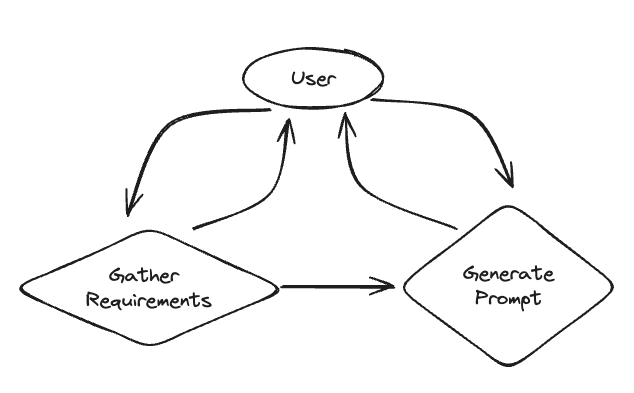

In [15]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")
        
os.environ["LANGSMITH_API_KEY"] = os.getenv('LANGSMITH_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langgraph-test"

这个将会创建一个生成提示词的agent

In [16]:
from typing import List

from langchain_core.messages import SystemMessage
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

from pydantic import BaseModel
import os

load_dotenv()

template = """Your job is to get information from a user about what type of prompt template they want to create.

You should get the following information from them:

- What the objective of the prompt is
- What variables will be passed into the prompt template
- Any constraints for what the output should NOT do
- Any requirements that the output MUST adhere to

If you are not able to discern this info, ask them to clarify! Do not attempt to wildly guess.

After you are able to discern all the information, call the relevant tool."""


def get_messages_info(messages):
    return [SystemMessage(content=template)] + messages


class PromptInstructions(BaseModel):
    """Instructions on how to prompt the LLM."""

    objective: str
    variables: List[str]
    constraints: List[str]
    requirements: List[str]


llm = ChatOpenAI(
  api_key=os.getenv('OPENAI_API_KEY'),
  base_url=os.getenv('OPENAI_BASE_URL'),
  model=os.getenv('MODEL_NAME')
)

llm_with_tool = llm.bind_tools([PromptInstructions])


def info_chain(state):
    messages = get_messages_info(state["messages"])
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

## 生成提示

In [17]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

# New system prompt
prompt_system = """Based on the following requirements, write a good prompt template:

{reqs}"""


# Function to get the messages for the prompt
# Will only get messages AFTER the tool call
def get_prompt_messages(messages: list):
    tool_call = None
    other_msgs = []
    for m in messages:
        if isinstance(m, AIMessage) and m.tool_calls:
            tool_call = m.tool_calls[0]["args"]
        elif isinstance(m, ToolMessage):
            continue
        elif tool_call is not None:
            other_msgs.append(m)
    return [SystemMessage(content=prompt_system.format(reqs=tool_call))] + other_msgs


def prompt_gen_chain(state):
    messages = get_prompt_messages(state["messages"])
    response = llm.invoke(messages)
    return {"messages": [response]}

## 定义状态逻辑

In [18]:
from typing import Literal

from langgraph.graph import END


def get_state(state):
    messages = state["messages"]
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        return "add_tool_message"
    elif not isinstance(messages[-1], HumanMessage):
        return END
    return "info"

## 创建图

In [19]:
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list, add_messages]


memory = InMemorySaver()
workflow = StateGraph(State)
workflow.add_node("info", info_chain)
workflow.add_node("prompt", prompt_gen_chain)


@workflow.add_node
def add_tool_message(state: State):
    return {
        "messages": [
            ToolMessage(
                content="Prompt generated!",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        ]
    }


workflow.add_conditional_edges("info", get_state, ["add_tool_message", "info", END])
workflow.add_edge("add_tool_message", "prompt")
workflow.add_edge("prompt", END)
workflow.add_edge(START, "info")
graph = workflow.compile(checkpointer=memory)

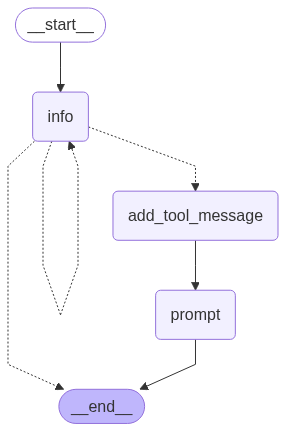

In [20]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## 调用

In [21]:
import uuid

cached_human_responses = ["hi!", "rag prompt", "1 rag, 2 none, 3 no, 4 no", "red", "q"]
cached_response_index = 0
config = {"configurable": {"thread_id": str(uuid.uuid4())}}
while True:
    try:
        user = input("User (q/Q to quit): ")
    except:
        user = cached_human_responses[cached_response_index]
        cached_response_index += 1
    print(f"User (q/Q to quit): {user}")
    if user in {"q", "Q"}:
        print("AI: Byebye")
        break
    output = None
    for output in graph.stream(
        {"messages": [HumanMessage(content=user)]}, config=config, stream_mode="updates"
    ):
        last_message = next(iter(output.values()))["messages"][-1]
        last_message.pretty_print()

    if output and "prompt" in output:
        print("Done!")

User (q/Q to quit): 我希望生成一个ai简历网站的提示词，这个网站主要可以支持简历修改，简历润色，ai一键生成简历，模版预览和简历案例等功能，我希望参考海外的知名的ai简历设计风格。给出好看的页面设计
================================== Ai Message ==================================

我理解您想要为AI简历网站生成一个设计相关的提示词，但让我澄清一下您的具体需求：

您是想让我帮您创建一个**提示词模板**，这个模板将用于让AI生成简历网站的设计方案，对吗？

如果是这样，我需要了解以下信息来为您创建合适的提示词模板：

**1. 这个提示词模板的最终目标是什么？**
- 让AI生成具体的网站UI设计稿吗？
- 还是生成设计规范文档？
- 或者是生成可直接使用的HTML/CSS代码？

**2. 这个模板需要哪些变量？** 
比如：
- {{style_preference}} - 用户偏好的设计风格（如：极简/现代/专业/有创意等）
- {{target_audience}} - 目标用户群体（如：学生/职场新人/高管等）  
- {{primary_color}} - 主色调
- {{site_name}} - 网站名称

**3. 设计输出的约束条件**（不希望出现什么）：
- 比如：不要使用过时的设计风格
- 不要包含不兼容移动端的设计
- 不要使用过于花哨的动画等

**4. 设计输出的必须要求**：
- 比如：必须包含深色模式
- 必须适配响应式设计
- 必须包含5个核心功能区块等

请告诉我这些具体信息，这样我就能为您创建出精准的提示词模板！
User (q/Q to quit): 这个提示词主要用来figma的ai功能来生成我的代码；需要变量：用户现代化的风格，有创意的，用户群体是所有人，主色调蓝色，网站名称帮我起一个吧；3，我希望输出不要过时的风格，可以参考知名的的设计风格，包含一定的动画效果等交互；4. 输出的话请先包含两个页面，首页和模版预览页面
================================== Ai Message ==================================

我会为您创建一个专门用于Figma AI